In [140]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import os

### TODO:
    1. Decreasing stepsize in FW (-1 for rho/gamma) + (rho to 1 to disable averaging)
    2. Full dataset training (deterministic FW)
    3. For medium & FW why p-norm is 6001 and not 20? gamma and t was trainable

In [537]:
# SMALL setting
setting_name = 'small'
common = {'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'repetitions': 1, 'architecture': '20_20'}
param_groups = {
    'sgd':
    [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.1, 'epochs': 100, **common}],
    
    'frankwolfe':
    [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'p': 2.0, 'R': 100.0, 'gamma': 0.01, 'ro': 0.6,
     'epochs': 200, **common}],
    
    'adam':
    [{'optimizer': 'adam', 'train_batch_size': 1000, 'p': 2.0, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
     'epochs': 200, **common}],
}

In [583]:
# medium setting
setting_name = 'medium_auto'
common = {'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
param_groups = {
    'sgd':
    [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': lr, 'epochs': 100, **common}
     for lr in [0.1, 0.01, 0.001, 0.0001]],
    
    'frankwolfe':
    [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': gamma, 'ro': ro,
     'epochs': 100, **common} for gamma in [-1.] + [0.1, 0.5, 1.]
     for ro in [-1.] + list(np.linspace(0, 1, 3))],
    
        'frankwolfe_deterministic':
    [{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': gamma, 'ro': 1.0,
     'epochs': 500, **common} for gamma in [-1.] + [0.1, 0.3, 0.5]],
    
    'adam':
    [{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': lr, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
     'epochs': 100, **common} for lr in [0.1, 0.01, 0.001, 0.0001]]
}

In [589]:
# BIG setting
setting_name = 'big'
common = {'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
param_groups = {
    'sgd':
    [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': lr, 'epochs': 1000, **common}
     for lr in [1., 0.5, 0.1, 0.05]],
    
    'frankwolfe_stochastic':
    [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': gamma, 'ro': ro,
     'epochs': 1000, **common} for gamma in [-1.] + [0.1, 0.5]
     for ro in [-1.] + [0.1, 0.3, 0.5]],
    
    'frankwolfe_deterministic':
    [{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': gamma, 'ro': 1.0,
     'epochs': 1000, **common} for gamma in [-1.] + [0.1, 0.5]],
    
    'adam':
    [{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': lr, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
     'epochs': 1000, **common} for lr in [0.01, 0.001, 0.0001]]
}

In [590]:
parameters = [x for group in param_groups.values() for x in group]

In [591]:
def varying_for_optim(d):
    """ What changes for optimizer? """
    d0 = d[0]
    keys = set()
    for v in d:
        for key, val in v.items():
            if d0[key] != val:
                keys.add(key)
    return list(keys)

# group -> what changes
varying = {group: varying_for_optim(param_groups[group]) for group in param_groups.keys()}

print(varying)

{'sgd': ['learning_rate'], 'frankwolfe_stochastic': ['gamma', 'ro'], 'frankwolfe_deterministic': ['gamma'], 'adam': ['learning_rate']}


In [592]:
def print_nice(y):
    if isinstance(y, float):
        return str(round(y, 10))#'%.2g' % y
    return str(y)

In [593]:
def print_one(**kwargs):
    return('python experiment.py ' + " ".join(['--' + x + ' ' + print_nice(y) for x, y in kwargs.items()]) + ' &')

In [594]:
# arguments in the correct order

f = open('experiment.py', 'r').readlines()

args_in_order = []
for l in f:
    k = 'parser.add_argument(\'--'
    if l.startswith(k):
        args_in_order.append(l[len(k):].split('\'')[0])

In [595]:
def get_file(**kwargs):
    return ("_".join([x + '-' + print_nice(kwargs[x] if x in kwargs else None) for x in args_in_order])+'.output')

In [597]:
out = open('run_' + setting_name + '.sh', 'w')

def write_to_out(s):
    print(s)
    out.write(s + '\n')

it = 0
for params in parameters:
    if it % 4 == 0:
        write_to_out('pids=""')
    write_to_out(print_one(**params))
    #print('echo aba; sleep 3 &')
    #print('pids="$pids $!"')
    if it % 2 == 1:
        write_to_out('sleep 5')
    
    if it % 4 == 3:
        write_to_out('wait $pids')
        write_to_out('sleep 5')
    it += 1
it = len(parameters)
print('Total runs: ', it)
print('Total time: ', common['repetitions'] * 3 * it / 4)

out.close()

pids=""
python experiment.py --optimizer sgd --train_batch_size 1000 --learning_rate 1.0 --epochs 1000 --image_side 10 --giveup 100 --accuracy_threshold 0.0 --p 3.0 --repetitions 15 --architecture 50_50_20 &
python experiment.py --optimizer sgd --train_batch_size 1000 --learning_rate 0.5 --epochs 1000 --image_side 10 --giveup 100 --accuracy_threshold 0.0 --p 3.0 --repetitions 15 --architecture 50_50_20 &
sleep 5
python experiment.py --optimizer sgd --train_batch_size 1000 --learning_rate 0.1 --epochs 1000 --image_side 10 --giveup 100 --accuracy_threshold 0.0 --p 3.0 --repetitions 15 --architecture 50_50_20 &
python experiment.py --optimizer sgd --train_batch_size 1000 --learning_rate 0.05 --epochs 1000 --image_side 10 --giveup 100 --accuracy_threshold 0.0 --p 3.0 --repetitions 15 --architecture 50_50_20 &
sleep 5
wait $pids
sleep 5
pids=""
python experiment.py --optimizer frankwolfe --train_batch_size 1000 --R 20.0 --gamma -1.0 --ro -1.0 --epochs 1000 --image_side 10 --giveup 100 --acc

In [570]:
def arr_of_dicts_to_dict_of_arrays(arr):
    """ Array of dicts to dict of arrays """
    all_keys = arr[0].keys()
    return {key: [v[key] for v in arr] for key in all_keys}

In [571]:
def process_dict(d, do_plot = True, use_random = True):
    """ Process one dictionary from  file, return key metrics or plot them """
    d0 = d
    d = arr_of_dicts_to_dict_of_arrays(d)
    all_keys = d.keys()
    metrics = d
    #print(metrics)
    name = '0'
    
    results = {key: [] for key in all_keys}
    results['hessian_eigens_mean'] = []
    results['hessian_eigens_max'] = []
    del results['hessian_eigens']
    
    for i in range(len(d0)):
        for key, val in metrics.items():
            if key == 'hessian_eigens':
                eigens = val[i]
                results['hessian_eigens_mean'].append(np.mean(eigens))
                results['hessian_eigens_max'].append(np.max(eigens))
            elif isinstance(val[i], list):
                results[key].append(val[i][-1]) # appending LAST loss/accuracy
            else:
                results[key].append(val[i])
    
    if do_plot:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('loss', color='b')
        ax1.tick_params('y', colors='b')
        
        ax2.set_ylabel('accuracy', color='r')
        ax2.tick_params('y', colors='r')
        
        for i in range(len(d0)):
            ax1.plot(metrics['train_loss'][i], label = 'train_loss')
            ax1.plot(metrics['test_loss'][i], label = 'test_loss')

            ax2.plot(metrics['train_acc'][i], label = 'train_acc')
            ax2.plot(metrics['test_acc'][i], label = 'test_acc')

        fig.tight_layout()
        fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
        plt.savefig('figures/' + name + '.eps', bbox_inches = 'tight')
        plt.show()

    return results

In [581]:
def process_file(f, do_plot = False):
    """ Process one file """
    if not os.path.isfile(f):
        print('!!! File  missing ' + f)
        return
    
    content = open(f, 'r').read()
    if content.startswith('Nothing['):
        print('!!! File  is empty')
        return
    try:
        d = eval(content)
        return process_dict(d, do_plot)
    except:
        print('!!! File  cannot be processed')
        return None
    #return d

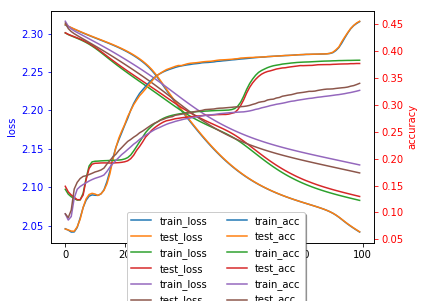

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.1, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
{'train_loss': [2.041463, 2.0827281, 2.1289213], 'test_loss': [2.0418203, 2.087829, 2.1185126], 'train_acc': [0.45496666, 0.38318333, 0.32713333], 'test_acc': [0.4557, 0.3771, 0.3402], 'p_norm': [11.834844, 11.961177, 11.902492], 'hessian_eigens_mean': [0.0009697952946015908, 0.0007877139841550352, 0.0005321308049746093], 'hessian_eigens_max': [0.27081317, 0.3014176, 0.22538441]}
-----


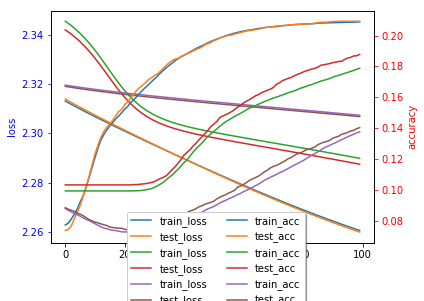

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.01, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
{'train_loss': [2.2605588, 2.2899063, 2.3074143], 'test_loss': [2.25991, 2.2875051, 2.3068807], 'train_acc': [0.20885, 0.17885, 0.1376], 'test_acc': [0.2093, 0.1878, 0.1403], 'p_norm': [11.06238, 11.106864, 11.186072], 'hessian_eigens_mean': [0.00043776970557880514, 0.00022043332719998233, 8.195407274134952e-05], 'hessian_eigens_max': [0.35560367, 0.13527842, 0.058709007]}
-----


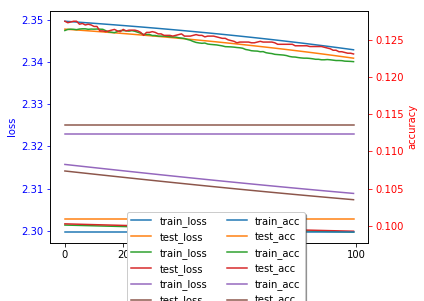

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.001, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
{'train_loss': [2.3430083, 2.299639, 2.3088326], 'test_loss': [2.3410056, 2.2998395, 2.3073382], 'train_acc': [0.09915, 0.12206667, 0.11236667], 'test_acc': [0.1009, 0.1231, 0.1135], 'p_norm': [11.14202, 10.678044, 11.00535], 'hessian_eigens_mean': [-8.564800694606927e-05, 8.878352286171099e-05, 3.1283267484211e-05], 'hessian_eigens_max': [0.01259858, 0.04672374, 0.049335677]}
-----


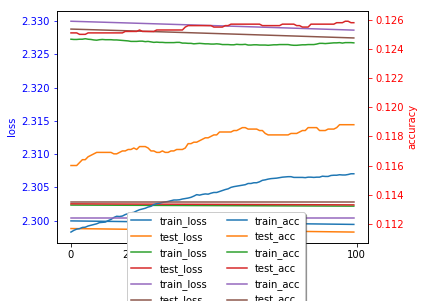

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.0001, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
{'train_loss': [2.2994442, 2.3021932, 2.3286529], 'test_loss': [2.2982945, 2.3023798, 2.3274763], 'train_acc': [0.115433335, 0.124416664, 0.11236667], 'test_acc': [0.1188, 0.1258, 0.1135], 'p_norm': [10.910071, 10.551251, 11.121029], 'hessian_eigens_mean': [7.553784513373137e-05, 7.191914303254311e-05, -0.00013096761155246173], 'hessian_eigens_max': [0.060758237, 0.046741974, 0.008962963]}
-----


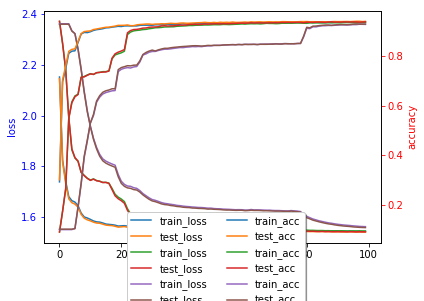

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': -1.0, 'ro': -1.0, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
{'train_loss': [1.5429562, 1.544887, 1.5619218], 'test_loss': [1.5406369, 1.5416254, 1.5582893], 'train_acc': [0.938, 0.93653333, 0.92865], 'test_acc': [0.9409, 0.9389, 0.9298], 'p_norm': [6001.0015, 6001.0015, 6001.0015], 'hessian_eigens_mean': [0.0014924967689348577, 0.001458445412956637, 0.0014961497647408893], 'hessian_eigens_max': [0.36965632, 0.3362363, 0.35704774]}
-----
!!! File  cannot be processed
{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': -1.0, 'ro': 0.0, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
None
-----


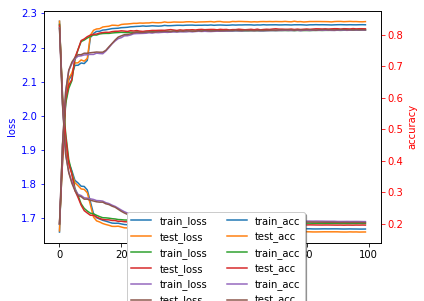

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': -1.0, 'ro': 0.5, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
{'train_loss': [1.6662874, 1.682826, 1.6881154], 'test_loss': [1.6576096, 1.6778758, 1.6851754], 'train_acc': [0.8311, 0.8139167, 0.81423336], 'test_acc': [0.8411, 0.8182, 0.8154], 'p_norm': [6001.0015, 6001.0015, 6001.0015], 'hessian_eigens_mean': [0.0015193325136256943, 0.0015026402541709755, 0.001497429252643864], 'hessian_eigens_max': [0.36323324, 0.3492587, 0.3863499]}
-----


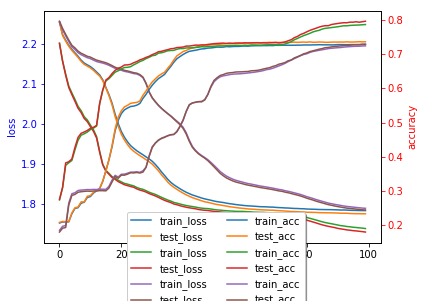

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': -1.0, 'ro': 1.0, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
{'train_loss': [1.782148, 1.737082, 1.7879479], 'test_loss': [1.7741543, 1.7282152, 1.7836761], 'train_acc': [0.7287833, 0.7866333, 0.7244], 'test_acc': [0.7364, 0.7963, 0.729], 'p_norm': [6001.0015, 6001.0015, 6001.0015], 'hessian_eigens_mean': [0.0014478164188381378, 0.0017136011536118161, 0.0011403181040103834], 'hessian_eigens_max': [0.38853404, 0.43300554, 0.2998051]}
-----


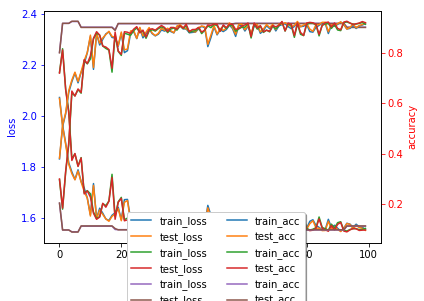

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.1, 'ro': -1.0, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
{'train_loss': [1.5572734, 1.5609267, 2.3487833], 'test_loss': [1.5534647, 1.5545377, 2.3476503], 'train_acc': [0.91475, 0.91228336, 0.11236667], 'test_acc': [0.9182, 0.9184, 0.1135], 'p_norm': [6001.0015, 6001.0015, 6001.0015], 'hessian_eigens_mean': [0.00045190877569057156, 0.0004900687100631886, -3.9798859203732163e-16], 'hessian_eigens_max': [0.0836683, 0.103192136, 4.9532257e-11]}
-----
!!! File  cannot be processed
{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.1, 'ro': 0.0, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
None
-----
!!! File  cannot be processed
{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.1, 'ro': 0.5, 'epochs':

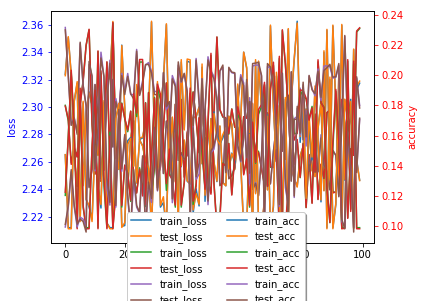

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.1, 'ro': 1.0, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
{'train_loss': [2.246591, 2.357413, 2.2910898], 'test_loss': [2.2462668, 2.357936, 2.2918773], 'train_acc': [0.19481666, 0.09871667, 0.18003333], 'test_acc': [0.1962, 0.098, 0.1783], 'p_norm': [6001.0015, 6001.0015, 6001.0015], 'hessian_eigens_mean': [9.123720076367896e-05, -7.1362491648715745e-06, 9.96838767771702e-05], 'hessian_eigens_max': [0.020872341, 0.004506043, 0.013152561]}
-----
!!! File  cannot be processed
{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.5, 'ro': -1.0, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
None
-----
!!! File  cannot be processed
{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.5, 'ro': 0.0, 'epochs': 10

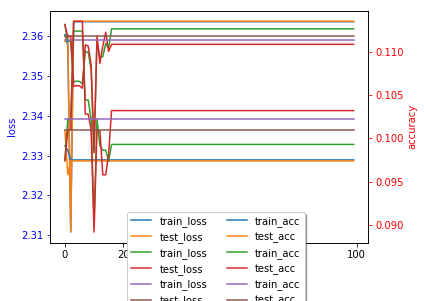

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.5, 'ro': 1.0, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
{'train_loss': [2.3636334, 2.36185, 2.3589666], 'test_loss': [2.3637502, 2.3579502, 2.36015], 'train_acc': [0.09751666, 0.0993, 0.102183335], 'test_acc': [0.0974, 0.1032, 0.101], 'p_norm': [6001.0015, 6001.0015, 6001.0015], 'hessian_eigens_mean': [-4.250316503313517e-18, -4.2829710301017255e-18, -4.041325313406131e-18], 'hessian_eigens_max': [4.284469e-15, 4.273061e-15, 4.0150996e-15]}
-----
!!! File  cannot be processed
{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 1.0, 'ro': -1.0, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
None
-----
!!! File  cannot be processed
{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 1.0, 'ro': 0.0, 'epochs':

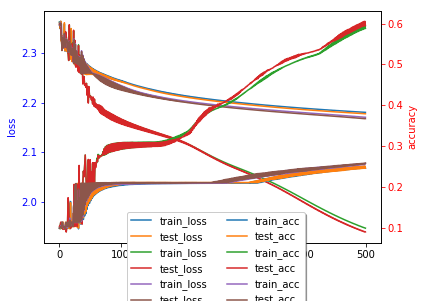

{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': -1.0, 'ro': 1.0, 'epochs': 500, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
{'train_loss': [2.1802487, 1.9469801, 2.1703413], 'test_loss': [2.177363, 1.939466, 2.1675732], 'train_acc': [0.24623333, 0.58823335, 0.25723332], 'test_acc': [0.2457, 0.5951, 0.2583], 'p_norm': [6.835641, 8.711302, 6.540719], 'hessian_eigens_mean': [0.00023098796129027895, 0.001169943011785345, 0.00024710617219276946], 'hessian_eigens_max': [0.14102536, 0.31528273, 0.16170716]}
-----


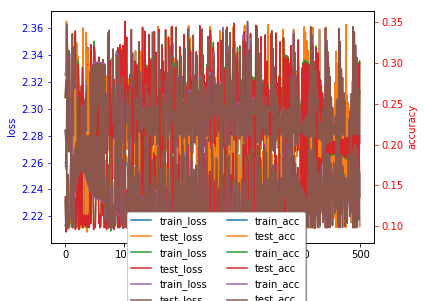

{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': 0.1, 'ro': 1.0, 'epochs': 500, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
{'train_loss': [2.3134973, 2.3356693, 2.274299], 'test_loss': [2.313838, 2.3345876, 2.274726], 'train_acc': [0.10023333, 0.13475, 0.1648], 'test_acc': [0.0994, 0.1363, 0.1645], 'p_norm': [501.00024, 501.0002, 501.0002], 'hessian_eigens_mean': [2.5755340463745504e-05, 3.109362829520253e-05, 0.00011875177798311451], 'hessian_eigens_max': [0.01061562, 0.0039451956, 0.018412631]}
-----


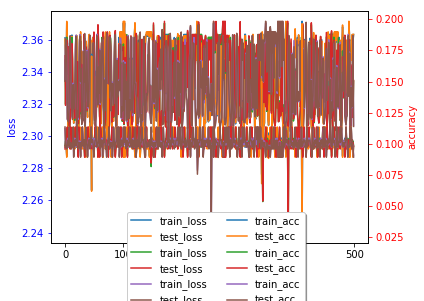

{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': 0.3, 'ro': 1.0, 'epochs': 500, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
{'train_loss': [2.3636334, 2.3345866, 2.3067367], 'test_loss': [2.3637502, 2.3349583, 2.3062599], 'train_acc': [0.09751666, 0.09871667, 0.09035], 'test_acc': [0.0974, 0.098, 0.0892], 'p_norm': [501.00116, 501.00082, 501.00024], 'hessian_eigens_mean': [-9.694143593131964e-17, -9.134937211556155e-07, 7.974156251532609e-06], 'hessian_eigens_max': [1.3219527e-13, 0.0035385778, 0.007603679]}
-----


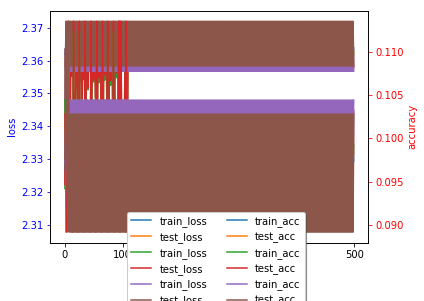

{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': 0.5, 'ro': 1.0, 'epochs': 500, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
{'train_loss': [2.3637834, 2.36185, 2.3567333], 'test_loss': [2.36295, 2.3579502, 2.3583503], 'train_acc': [0.09736667, 0.0993, 0.10441667], 'test_acc': [0.0982, 0.1032, 0.1028], 'p_norm': [13.876582, 13.882158, 13.875588], 'hessian_eigens_mean': [-9.836128596668828e-18, -8.188970583439248e-18, -8.904467477813955e-18], 'hessian_eigens_max': [8.031536e-15, 6.70224e-15, 7.2691605e-15]}
-----


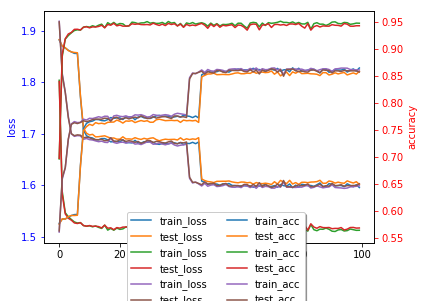

{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': 0.1, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
{'train_loss': [1.5956255, 1.5125172, 1.5989395], 'test_loss': [1.601817, 1.5170051, 1.6029695], 'train_acc': [0.86535, 0.94846666, 0.8617], 'test_acc': [0.8591, 0.9438, 0.8578], 'p_norm': [148.89343, 145.82802, 159.20079], 'hessian_eigens_mean': [5.572441427873724e-05, 2.882542501569293e-05, 2.6622955130103464e-05], 'hessian_eigens_max': [0.023067497, 0.027450074, 0.019985264]}
-----


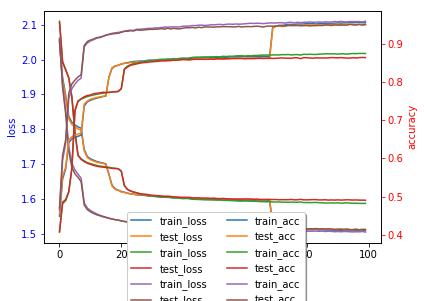

{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': 0.01, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
{'train_loss': [1.5082935, 1.5868391, 1.5043429], 'test_loss': [1.5117545, 1.5959167, 1.5114578], 'train_acc': [0.9558333, 0.8753667, 0.95995], 'test_acc': [0.9514, 0.8646, 0.9511], 'p_norm': [46.22751, 45.99372, 47.0765], 'hessian_eigens_mean': [0.0010862124919773, 0.000849842095355581, 0.0010389958478379756], 'hessian_eigens_max': [0.22416656, 0.21311548, 0.19344227]}
-----


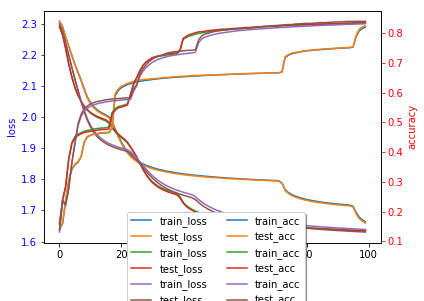

{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
{'train_loss': [1.6638855, 1.6348042, 1.6387026], 'test_loss': [1.6592063, 1.6342003, 1.6304437], 'train_acc': [0.82011664, 0.8354, 0.83161664], 'test_acc': [0.8242, 0.8341, 0.84], 'p_norm': [21.77904, 22.604525, 22.650179], 'hessian_eigens_mean': [0.0007525419676202431, 0.0006638412816141366, 0.0006615405544249872], 'hessian_eigens_max': [0.18298927, 0.1598458, 0.13543814]}
-----


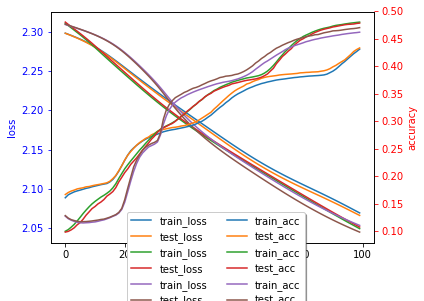

{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': 0.0001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
{'train_loss': [2.0690982, 2.0490115, 2.0531795], 'test_loss': [2.0659187, 2.0510492, 2.0446208], 'train_acc': [0.43101665, 0.48015, 0.4618], 'test_acc': [0.4332, 0.4783, 0.4701], 'p_norm': [12.030958, 12.308305, 12.262528], 'hessian_eigens_mean': [0.0007150394802208879, 0.0007674103252531514, 0.0007509612679514911], 'hessian_eigens_max': [0.17921089, 0.168709, 0.16248937]}
-----
Done: 18/28


In [587]:
# parameter id -> processed file
params_to_processed = []
done = 0
for param in parameters:
    fs = process_file(get_file(**param), True)
    print(param)
    print(fs)
    print("-----")
    if fs is not None:
        done += 1
    params_to_processed.append(fs)
print('Done: %d/%d' % (done, len(parameters)))

In [550]:
def selection_metric(summary):
    """ Summary of one element in params_to_processed[], a number
    Using mean test accuracy over runs
    """
    return np.mean(summary['test_acc']) if summary is not None else -1

In [551]:
def param_to_result(param):
    """ Parameter setting to results summary """
    idx = parameters.index(param)
    return params_to_processed[idx]

In [552]:
def select_best(optim):
    """ Select best parameters for an optimizer """
    
    metrics = [selection_metric(param_to_result(p)) for p in param_groups[optim]]
    best_idx = np.argmax(metrics)
    return parameters.index(param_groups[optim][best_idx])

In [555]:
for optim in param_groups.keys():
    idx = select_best(optim) # best hyperparameter
    print(optim, params_to_processed[idx])

sgd {'train_loss': [2.041463, 2.0827281, 2.1289213], 'test_loss': [2.0418203, 2.087829, 2.1185126], 'train_acc': [0.45496666, 0.38318333, 0.32713333], 'test_acc': [0.4557, 0.3771, 0.3402], 'p_norm': [11.834844, 11.961177, 11.902492], 'hessian_eigens_mean': [0.0009697952946015908, 0.0007877139841550352, 0.0005321308049746093], 'hessian_eigens_max': [0.27081317, 0.3014176, 0.22538441]}
frankwolfe {'train_loss': [1.5429562, 1.544887, 1.5619218], 'test_loss': [1.5406369, 1.5416254, 1.5582893], 'train_acc': [0.938, 0.93653333, 0.92865], 'test_acc': [0.9409, 0.9389, 0.9298], 'p_norm': [6001.0015, 6001.0015, 6001.0015], 'hessian_eigens_mean': [0.0014924967689348577, 0.001458445412956637, 0.0014961497647408893], 'hessian_eigens_max': [0.36965632, 0.3362363, 0.35704774]}
frankwolfe_deterministic None
adam {'train_loss': [1.5082935, 1.5868391, 1.5043429], 'test_loss': [1.5117545, 1.5959167, 1.5114578], 'train_acc': [0.9558333, 0.8753667, 0.95995], 'test_acc': [0.9514, 0.8646, 0.9511], 'p_norm': 

25